In [1]:
import os
import numpy as np
import sys
import h5py
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
ROOT_DIR = '../'
sys.path.insert(0, os.path.abspath(f'/{ROOT_DIR}/heart_rhythm_analysis/'))    # make repo root importable

from heart_rhythm_analysis.get_data.CapnoBaseETL import CapnoBaseETL
from heart_rhythm_analysis.get_data.MimicETL import MimicETL

bSetUpDB = True

In [2]:
def load_as_df(file_path, filename, store_signals=True, bPlot=True):
    h5_path = f"{file_path}/{filename}.h5"
    hf = h5py.File(h5_path, "r")

    rows = []
    for subj in hf.keys():
        subj_grp = hf[subj]
        for win_id in subj_grp.keys():
            win_grp = subj_grp[win_id]
            rec_id = win_grp.attrs['rec_id']
            label = win_grp.attrs['label']
            raw_ppg = win_grp["raw_ppg"][:]
            proc_ppg = win_grp["proc_ppg"][:]
            raw_ekg = win_grp["raw_ekg"][:]
            raw_abp = win_grp["raw_abp"][:]
            ekg_fs = win_grp.attrs["ekg_fs"]
            ppg_fs = win_grp.attrs["ppg_fs"]
            abp_fs = win_grp.attrs["abp_fs"]
            notes = win_grp.attrs["notes"]
            row_data = {
                "subject": subj,
                "window_id": win_id,
                "rec_id": rec_id,
                "label": label,
                "ppg_fs_out": ppg_fs,
                "ekg_fs_out": ekg_fs,
                "abp_fs_out":abp_fs,
                "raw_len": len(raw_ppg),
                "proc_len": len(proc_ppg),
                "duration_raw_s": len(raw_ppg) / ppg_fs,
                "duration_proc_s": len(proc_ppg) / ppg_fs,
                "notes": notes
            }
            if store_signals:
                row_data["raw_ppg"] = raw_ppg
                row_data["proc_ppg"] = proc_ppg
                row_data["raw_ekg"] = raw_ekg    
                row_data["raw_abp"] = raw_abp         
            rows.append(row_data)

    df = pd.DataFrame(rows)
    print(f"\nTotal windows: {len(df)}")
    if bPlot:
        first = df.iloc[np.random.randint(0, len(df))]
        y = first["proc_ppg"]
        t = np.arange(len(y)) / first.ppg_fs_out
        notes = first['notes']
        
        plt.figure(figsize=(15,7))
        plt.subplot(311)
        plt.plot(t, y)
        plt.title(f"Subject {first.subject} – Window {first.window_id}\nfs={first.ppg_fs_out} Hz")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")

        plt.subplot(312)
        y = first["raw_ekg"]
        t = np.arange(len(y)) / first.ekg_fs_out
        plt.plot(t,y)
        plt.title(f"fs={first.ekg_fs_out} Hz")
        
        plt.subplot(313)
        y = first["raw_abp"]
        t = np.arange(len(y)) / first.abp_fs_out
        plt.plot(t,y)
        plt.title(f"fs={first.abp_fs_out} Hz")
        
        plt.tight_layout()
        plt.show()
    hf.close()
    return df

# Create Capno Dataset

In [ ]:
def main():
    root_path = os.path.join('../data/raw/capnobase/data/mat')
    out_path = os.path.join('../data/processed/length_full/capnobase_db')
    out_filename = 'capnobase_db'
    if not os.path.exists(out_path):
        os.mkdir(out_path)

    fs_in = 100.00
    fs_out = 100.00

    config = {
    "input_dir"      : root_path,
    "output_dir"     : out_path,
    "window_size_sec": 30,
    "fs_in"          : fs_in,
    "fs_out"   : fs_out,
    "lowpass_cutoff" : (fs_out / 2),
    "fir_numtaps"    : 129,
    "zero_phase"     : True,
    "out_filename" :  out_filename
}
    if bSetUpDB:
        etl = CapnoBaseETL(config)
        h5file = etl.process_all()
        print(f"Saved windows HDF5 to {h5file}")
    df = load_as_df(out_path,out_filename)

    display(df.head(10))
    return df
if __name__ == "__main__":
    df_capnobase = main()

# MIMIC III AF DATASET

In [ ]:

def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_af_data.mat')
    out_filename = 'mimic_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 125.00,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "decimate_signal": False,
        "out_filename": out_filename
    }
    # if bSetUpDB:
    #     etl = MimicETL(config)
    #     out_file = etl.process()
    #     print("Saved AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df

if __name__ == "__main__":
    df_mimc_af = main()
    

# MIMIC III Non-AF Dataset

In [ ]:

def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_non_af_data.mat')
    out_filename = 'mimic_non_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_non_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 125.00,
        "window_size_sec": 30,
        "scale_type": None,
        "decimate_signal": False,
        "zero_phase": True,
        "out_filename": out_filename   
    }
    if bSetUpDB:
        etl = MimicETL(config)
        out_file = etl.process()
        print("Saved non AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimc_nonaf = main()

# MIMIC III General Subset

Loading ../data/raw/mimic3_data/_mimic3_struct.mat
Saved General MIMIC III windows to ../data/processed/length_full/mimic3_db/mimic3_db.h5

Total windows: 6000


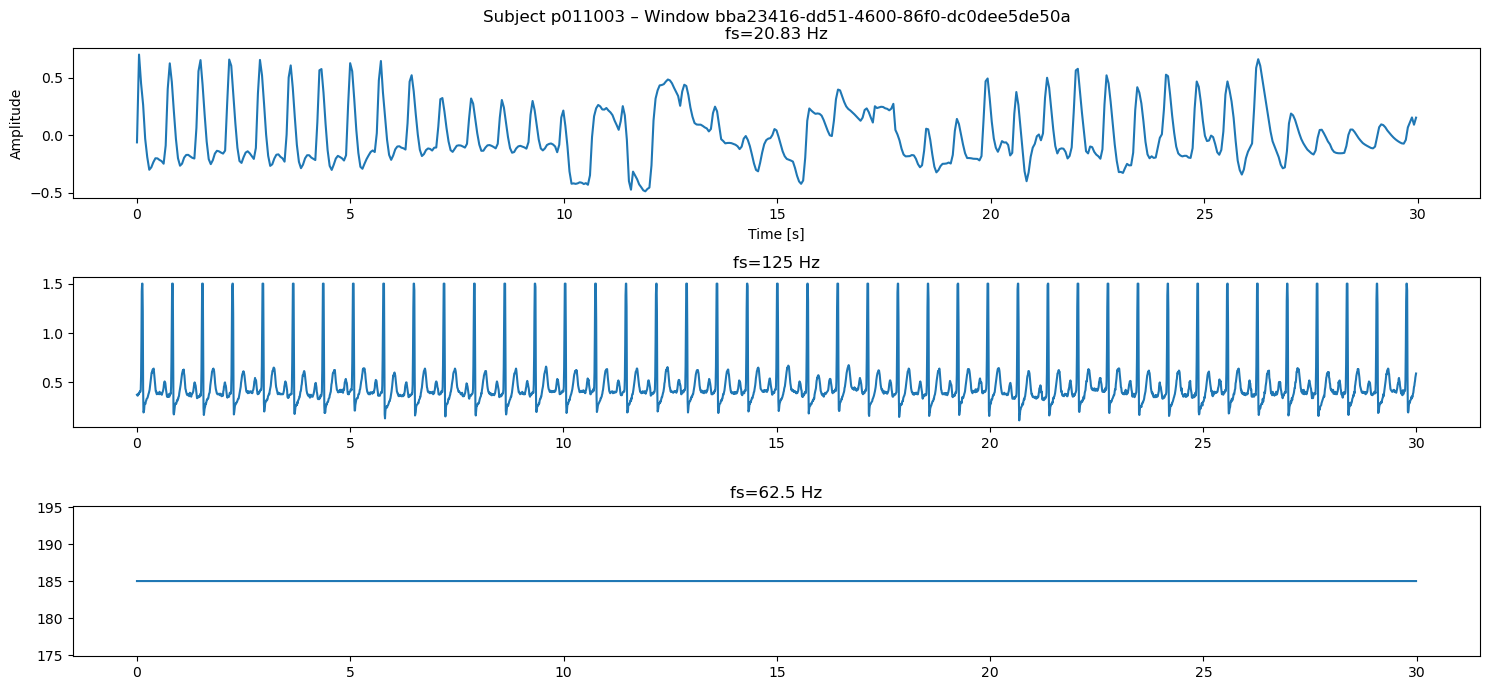

,subject,window_id,rec_id,label,ppg_fs_out,ekg_fs_out,abp_fs_out,raw_len,proc_len,duration_raw_s,duration_proc_s,notes,raw_ppg,proc_ppg,raw_ekg,raw_abp
0,p000160,03ba8cc0-77e4-42e3-bc62-736dd62c37b7,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.5259042033235581, 0.5268817204301075, 0.528...","[-0.33310115, 0.07023388, -0.03228736, 0.04323...","[0.6, 0.596078431372549, 0.596078431372549, 0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,p000160,047834f5-4991-4a8d-befd-726836b3c670,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.41055718475073316, 0.4066471163245357, 0.40...","[-0.51687086, -0.078476965, -0.22280553, -0.17...","[0.5745098039215686, 0.6058823529411764, 0.790...","[117.3403633248783, 117.9270651415027, 118.122..."
2,p000160,069a8a76-8f60-408a-a9cd-d9831b9bf407,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.512218963831867, 0.5102639296187683, 0.5083...","[-0.1765472, 0.060587704, -0.004865229, 0.0317...","[0.5509803921568628, 0.5294117647058824, 0.539...","[75.6845343445465, 75.09783252792211, 74.70669..."
3,p000160,09abe771-0954-4322-b52a-6b154b4a7801,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.7018572825024438, 0.7018572825024438, 0.701...","[-0.24492769, 0.7550723, 0.43513805, 0.5091075...","[0.596078431372549, 0.5745098039215686, 0.5843...","[11.538469060279699, 11.538469060279699, 11.53..."
4,p000160,09e78084-8ef8-4ab6-91fc-da2e03db402e,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.5180840664711632, 0.5171065493646139, 0.516...","[-0.7501027, 0.2498973, -0.01166743, 0.1313299...","[0.6352941176470588, 0.615686274509804, 0.6156...","[99.54374155393842, 98.37033792068964, 96.6102..."
5,p000160,0cae08ef-d92a-43ba-a9ec-2c520f032d51,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.581622678396872, 0.5894428152492669, 0.5953...","[-0.2322985, 0.18775737, 0.12274659, 0.1994481...","[0.5745098039215686, 0.5843137254901961, 0.596...","[93.67672338769451, 93.48115611548639, 92.6988..."
6,p000160,0f8e6f91-b41d-481d-a4e2-1a415f1be31d,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.5865102639296188, 0.5865102639296188, 0.586...","[-0.55812335, 0.44187665, 0.18536597, 0.320814...","[0.6705882352941176, 0.7215686274509804, 0.754...","[83.89835977728798, 83.50722523287172, 82.9205..."
7,p000160,11ed3000-00c0-43cd-bb08-b67771d545f2,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.5249266862170088, 0.5249266862170088, 0.524...","[-0.5837611, 0.22116715, -0.0007377863, 0.0935...","[0.615686274509804, 0.6098039215686275, 0.6156...","[109.51767243655308, 106.19302880901486, 103.0..."
8,p000160,123d5875-dfbe-4020-877a-443e861b07c7,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.5425219941348973, 0.5386119257086999, 0.534...","[-0.3566029, 0.14933896, -0.016001582, 0.03796...","[0.24901960784313726, 0.3235294117647059, 0.47...","[122.62067967449782, 122.81624694670596, 122.8..."
9,p000160,12bf4d30-2a7d-438e-ae96-2f113f7e366f,3531764_0003,-1,20.83,125,62.5,3750,625,180.028805,30.004801,,"[0.5386119257086999, 0.5405669599217986, 0.541...","[-0.6831115, 0.3168885, 0.045017898, 0.1497321...","[0.6, 0.6411764705882353, 0.7098039215686275, ...","[83.89835977728798, 83.50722523287172, 83.5072..."


In [ ]:
def main():
    root_path = os.path.join('../data/raw/mimic3_data/_mimic3_struct.mat')
    out_filename = 'mimic3_db'
    out_path = os.path.join('../data/processed/length_full/mimic3_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        'fs_ekg': 125,
        'fs_bp':125,
        "window_size_sec": 30,
        "scale_type": "norm",
        "decimate_signal": True,
        "zero_phase": True,
        "out_filename": out_filename 
    }
    bSetUpDB = True
    if bSetUpDB:
        etl = MimicETL(config)
        out_file = etl.process()
        print("Saved General MIMIC III windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic_gen = main()

# MIMIC IV Data

In [ ]:
np.random.seed(42)
def main():
    substring = ''
    file_name = f'_{substring}' if len(substring) > 0 else ""
    root_path = os.path.join(f'../data/raw/mimic4_data/_mimic4{file_name}_struct.mat')
    out_filename = f'mimic4{file_name}_db'
    out_path = os.path.join(f'../data/processed/length_full/{out_filename}')

    if not os.path.exists(out_path):
        os.mkdir(out_path)
    fs_in = 62.5
    fs_out = 20.83
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": fs_in,
        "fs_out": fs_out,
        'fs_ekg': 62.5, 
        'fs_bp':125,
        "window_size_sec": 30,
        "scale_type": "norm",
        "decimate_signal": True,
        "zero_phase": True,
        "out_filename": out_filename 
    }
    if bSetUpDB:
        etl = MimicETL(config)
        out_file = etl.process()
        print(f"Saved {substring} MIMIC IV  windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic4_gen = main()


In [ ]:
from heart_rhythm_analysis.get_data.prepare_dataset import my_split_and_save

ROOT_PATH = '../data/processed/length_full'
file_paths = [f"{ROOT_PATH}/mimic3_db/mimic3_db.h5", f"{ROOT_PATH}/mimic4_db/mimic4_db.h5"]
out_path = '../data/development_dataset/length_full'
train_path, test_path = my_split_and_save(file_paths, train_ratio=0.8, output_dir=out_path)

In [ ]:
import h5py
import os

def count_windows(h5_path):
    with h5py.File(h5_path, 'r') as f:
        subjects = list(f.keys())
        n_subjects = len(subjects)
        n_windows  = sum(len(f[subj].keys()) for subj in subjects)
    return n_subjects, n_windows

# Replace these with your real paths:
paths = {
    "mimic3": "../data/processed/length_full/mimic3_db/mimic3_db.h5",
    "mimic4": "../data/processed/length_full/mimic4_db/mimic4_db.h5",
    "train":   "../data/development_dataset/length_full/train_datasett.h5",
    "test":    "../data/development_dataset/length_full/test_datasett.h5",
}

for name, p in paths.items():
    if os.path.exists(p):
        subs, wins = count_windows(p)
        print(f"{name:>6} → {subs} subjects, {wins} windows")
    else:
        print(f"{name:>6} → file not found: {p}")

In [ ]:
import inspect
from heart_rhythm_analysis.get_data.prepare_dataset import my_split_and_save
print(inspect.getsource(my_split_and_save))